In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
from prettytable import PrettyTable
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import cluster

import dtale

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use('default')  # 'dark_background'

In [5]:
batting = pd.read_csv("Batting.csv")
fielding = pd.read_csv("Fielding.csv")
#pitching = pd.read_csv("Pitching.csv")

In [ ]:
batting

In [5]:
#pitching

In [6]:
fielding
#fielding.drop(['lgID', 'PB', 'WP', 'SB', 'CS', 'ZR'], axis = 1, inplace = True)
#fielding.dropna(axis = 0, how = 'any', inplace = True)

,playerID,yearID,stint,teamID,lgID,POS,G,GS,InnOuts,PO,A,E,DP,PB,WP,SB,CS,ZR
0,abercda01,1871,1,TRO,NaN,SS,1,1.0,24.0,1,3,2.0,0,NaN,NaN,NaN,NaN,NaN
1,addybo01,1871,1,RC1,NaN,2B,22,22.0,606.0,67,72,42.0,5,NaN,NaN,NaN,NaN,NaN
2,addybo01,1871,1,RC1,NaN,SS,3,3.0,96.0,8,14,7.0,0,NaN,NaN,NaN,NaN,NaN
3,allisar01,1871,1,CL1,NaN,2B,2,0.0,18.0,1,4,0.0,0,NaN,NaN,NaN,NaN,NaN
4,allisar01,1871,1,CL1,NaN,OF,29,29.0,729.0,51,3,7.0,1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147075,zimmejo02,2021,1,MIL,NL,P,2,0.0,17.0,0,1,0.0,0,NaN,NaN,0.0,0.0,NaN
147076,zimmeky01,2021,1,KCA,AL,P,52,2.0,162.0,4,5,0.0,3,NaN,NaN,2.0,1.0,NaN
147077,zimmery01,2021,1,WAS,NL,1B,54,45.0,1202.0,338,15,0.0,30,NaN,NaN,NaN,NaN,NaN
147078,zuberty01,2021,1,KCA,AL,P,31,0.0,82.0,1,3,0.0,0,NaN,NaN,0.0,0.0,NaN


In [8]:
aggregation_functions_f = {'POS': 'first', 'G': 'sum','GS': 'sum', 'InnOuts':'sum',
                           'PO':'sum','A':'sum','E':'sum','DP':'sum'}
combined_f = fielding.groupby(fielding['playerID']).aggregate(aggregation_functions_f)
aggregation_functions_b = {'G': 'sum','AB': 'sum', 'R':'sum','H':'sum',
                           '2B':'sum','3B':'sum','HR':'sum','RBI':'sum','SB':'sum',
                           'CS':'sum','BB':'sum','SO':'sum','IBB':'sum','HBP':'sum',
                           'SH':'sum','SF':'sum','GIDP':'sum'}
combined_b = batting.groupby(fielding['playerID']).aggregate(aggregation_functions_b)
merged_df = pd.merge(combined_f,combined_b, on='playerID',how = 'outer')
merged_df = merged_df.fillna(0)

In [9]:
merged_df

,POS,G_x,GS,InnOuts,PO,A,E,DP,G_y,AB,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
playerID,,,,,,,,,,,,,,,,,,,,,
aardsda01,P,331,0.0,1011.0,11,29,3.0,2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaronha01,OF,3020,2977.0,78414.0,7436,429,144.0,218,2256.0,6349.0,...,794.0,188.0,84.0,738.0,980.0,60.0,51.0,55.0,45.0,128.0
aaronto01,1B,387,206.0,6472.0,1317,113,22.0,124,1035.0,2955.0,...,342.0,75.0,32.0,343.0,507.0,28.0,8.0,32.0,12.0,65.0
aasedo01,P,448,91.0,3328.0,67,135,13.0,10,741.0,1628.0,...,222.0,35.0,12.0,128.0,349.0,5.0,21.0,18.0,10.0,40.0
abadan01,1B,9,4.0,138.0,37,1,1.0,3,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zupofr01,C,13,1.0,114.0,31,1,2.0,0,223.0,707.0,...,87.0,29.0,19.0,49.0,59.0,6.0,2.0,3.0,7.0,12.0
zuvelpa01,SS,201,136.0,3844.0,267,415,23.0,84,733.0,1590.0,...,233.0,6.0,4.0,147.0,316.0,10.0,21.0,12.0,17.0,42.0
zuverge01,P,265,31.0,1847.0,45,145,7.0,10,483.0,1082.0,...,97.0,16.0,8.0,79.0,153.0,8.0,7.0,10.0,7.0,19.0


In [9]:
d = dtale.show(merged_df)
d

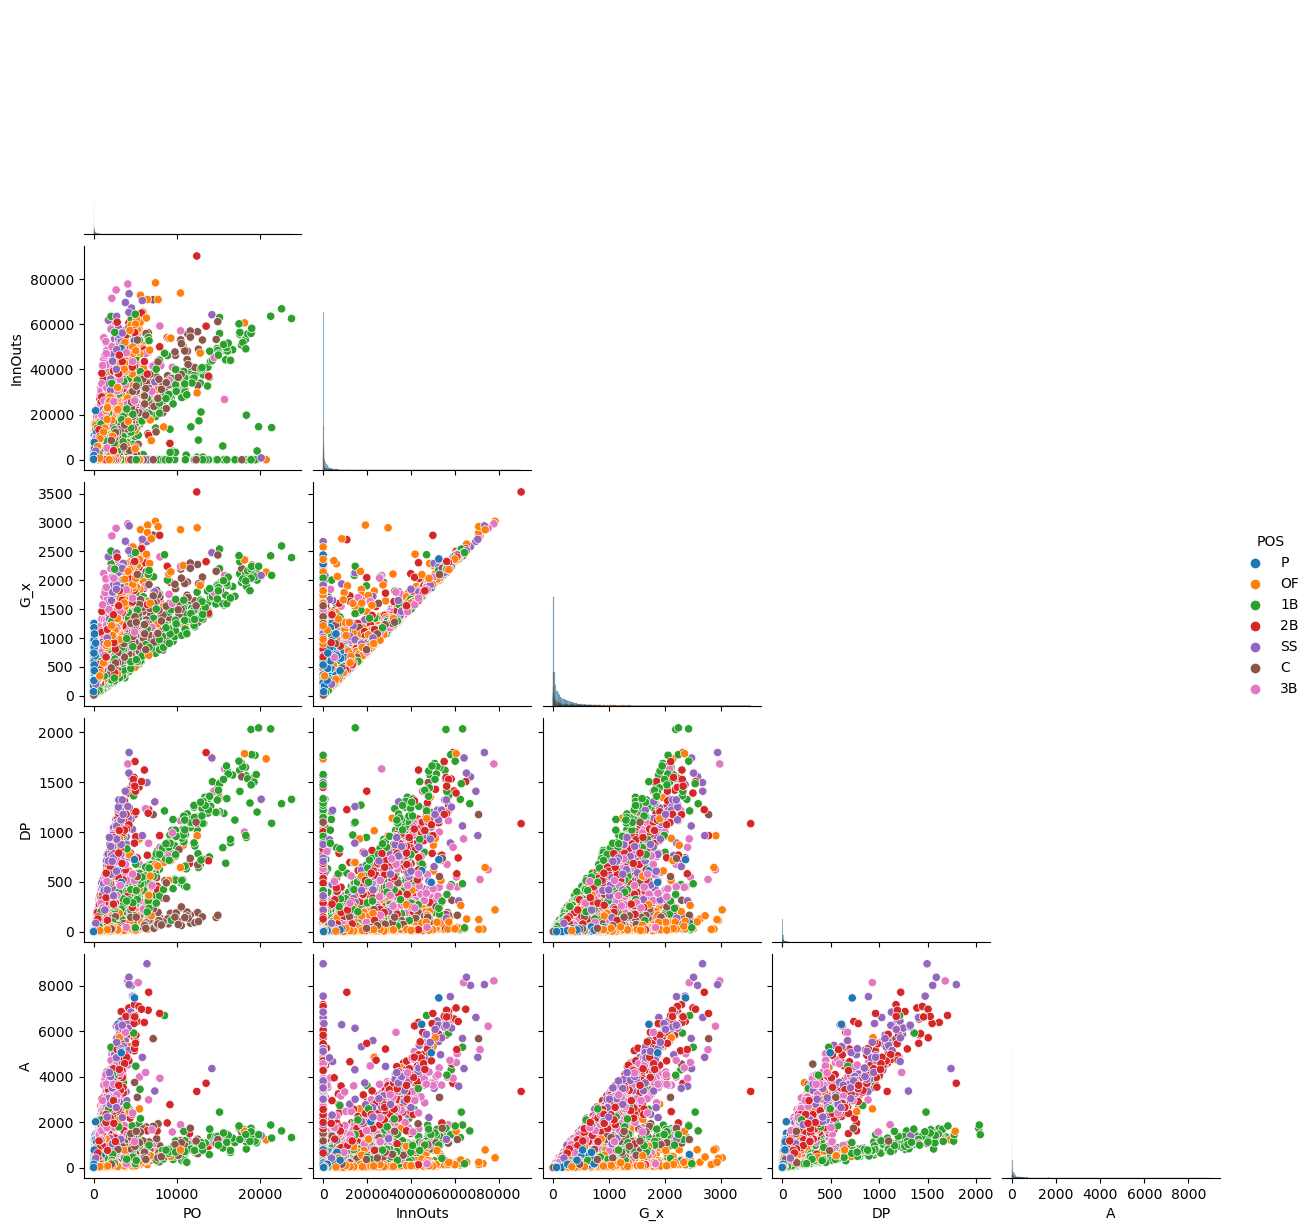

In [39]:
sns.pairplot(data = merged_df,hue='POS', diag_kind ="hist",corner = True,x_vars=['PO','InnOuts','G_x','DP','A'],y_vars=['PO','InnOuts','G_x','DP','A'])

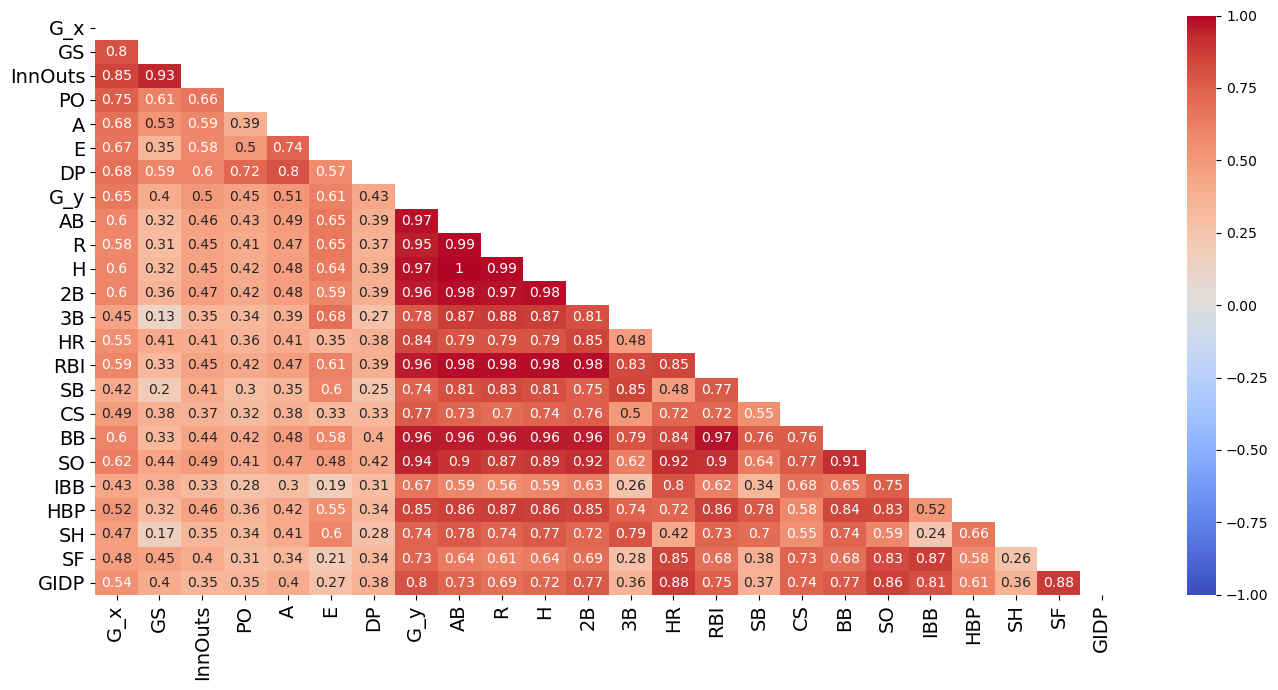

In [11]:
corr = merged_df.corr()
fig, ax = plt.subplots(figsize=(14,7))
mask = np.zeros_like(corr, dtype=bool)  
mask[np.triu_indices_from(mask)] = True  
ax = sns.heatmap(corr.round(2), mask=mask, ax=ax, annot=True, vmin=-1, vmax=1,annot_kws={'fontsize':10}, cmap='coolwarm')
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)
plt.tight_layout()
plt.show()

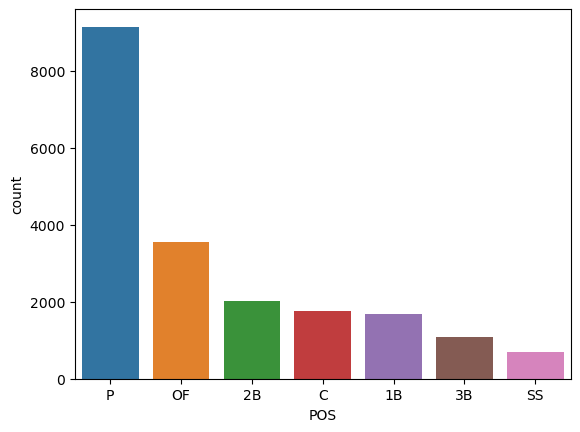

In [12]:
ax = sns.countplot(x="POS",data=merged_df,order=merged_df['POS'].value_counts().index)

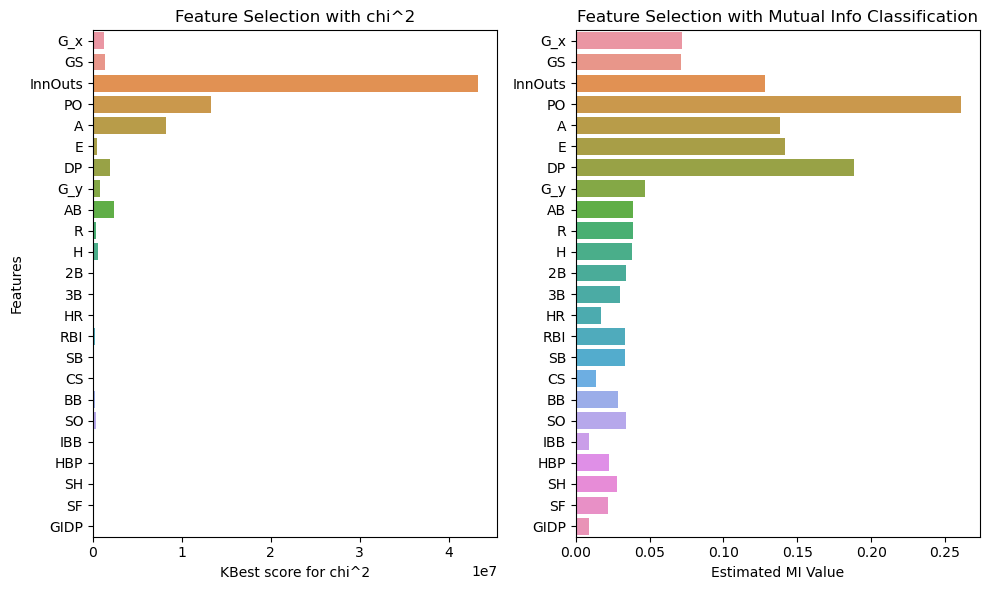

In [13]:
fig, axs = plt.subplots(1, 2, sharey=False, figsize=(10, 6))

feature_selectors = {
    0: [chi2, 'KBest score for chi^2', 'Feature Selection with chi^2'], 
    1: [mutual_info_classif, 'Estimated MI Value', 'Feature Selection with Mutual Info Classification']
}

for i in range(2):
    # Learn relationship from data
    f_sel = SelectKBest(score_func=feature_selectors[i][0], k='all').fit(merged_df.drop('POS',axis=1),merged_df['POS'])
    # Transform input data
    x_fs = f_sel.transform(merged_df.drop('POS',axis=1))
    # Plot score for each feature
    sns.barplot(x=f_sel.scores_, y=list(merged_df.drop('POS',axis=1).columns), orient='h', ax=axs[i])
    axs[i].set_xlabel(feature_selectors[i][1])
    axs[i].set_title(feature_selectors[i][2])

axs[0].set_ylabel('Features')
plt.tight_layout()
plt.show()

In [14]:
y = merged_df['POS']
X = merged_df.drop('POS', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [41]:
y_train

playerID
croftar01    OF
felizpe01    3B
kommefr01    OF
comerst01     P
applilu01    SS
             ..
marteje01    1B
varnepe01     C
yamagsh01     P
keplema01    OF
boyleji01     C
Name: POS, Length: 13974, dtype: object

Train: 0.4932 
Test: 0.49482


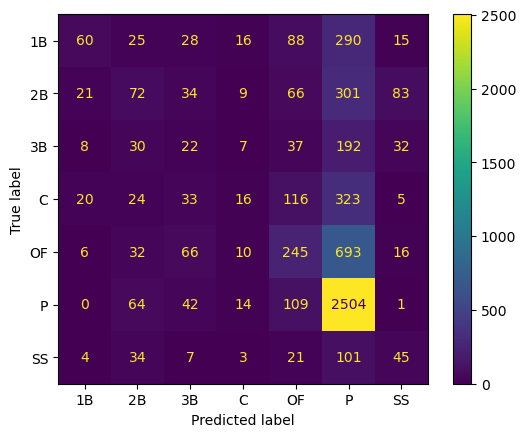

In [15]:
nb = GaussianNB()
nb.fit(X_train, y_train)
nb_pred = nb.predict(X_test)
print('Train:', nb.score(X_train, y_train).round(5), '\nTest:', nb.score(X_test, y_test).round(5))
cm = confusion_matrix(y_test,nb_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['1B','2B','3B','C','OF','P','SS'])
cm_display.plot()
plt.show()

Train: 0.71547 
Test: 0.71803


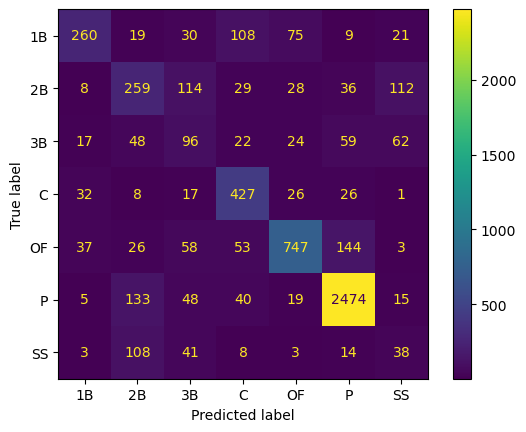

In [16]:
sgd = SGDClassifier(loss='modified_huber',shuffle=True, random_state=53)
sgd.fit(X_train, y_train)
sgd_pred = sgd.predict(X_test)
print('Train:', sgd.score(X_train, y_train).round(5), '\nTest:', sgd.score(X_test, y_test).round(5))
cm = confusion_matrix(y_test,sgd_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['1B','2B','3B','C','OF','P','SS'])
cm_display.plot()
plt.show()

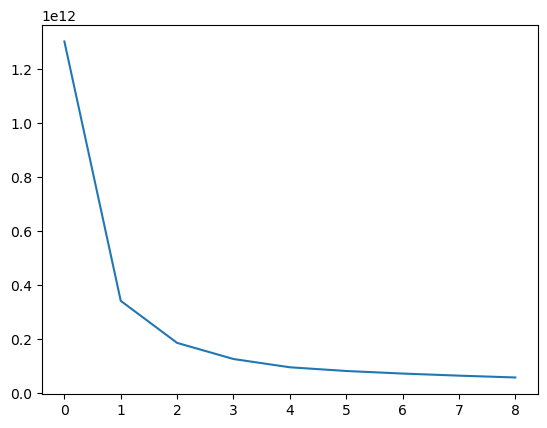

In [17]:
n_clusters = list(range(1, 10))
within_cluster_var = []
for i in n_clusters:
    clu = cluster.KMeans(n_clusters=i)
    clu = clu.fit(X_train)
    within_cluster_var.append(clu.inertia_)
plt.plot(within_cluster_var)

Train: 0.78016 
Test: 0.6626


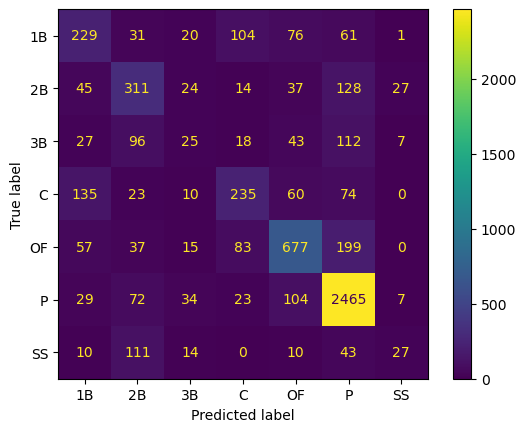

In [18]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train,y_train)
knn_pred = knn.predict(X_test)
print('Train:', knn.score(X_train, y_train).round(5), '\nTest:', knn.score(X_test, y_test).round(5))
cm = confusion_matrix(y_test,knn_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['1B','2B','3B','C','OF','P','SS'])
cm_display.plot()
plt.show()

Train: 0.99936 
Test: 0.72671


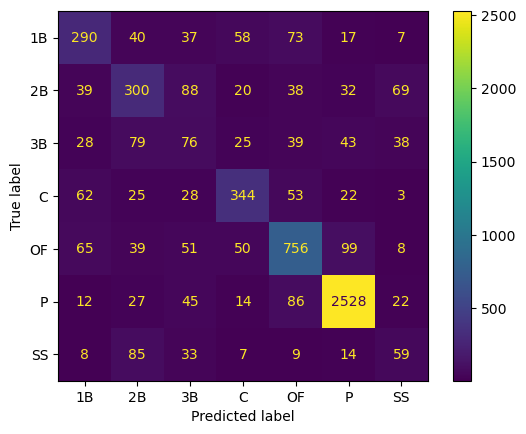

In [19]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train,y_train)
dt_pred = dt.predict(X_test)
print('Train:', dt.score(X_train, y_train).round(5), '\nTest:', dt.score(X_test, y_test).round(5))
cm = confusion_matrix(y_test,dt_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['1B','2B','3B','C','OF','P','SS'])
cm_display.plot()
plt.show()

Train: 0.99936 
Test: 0.79833


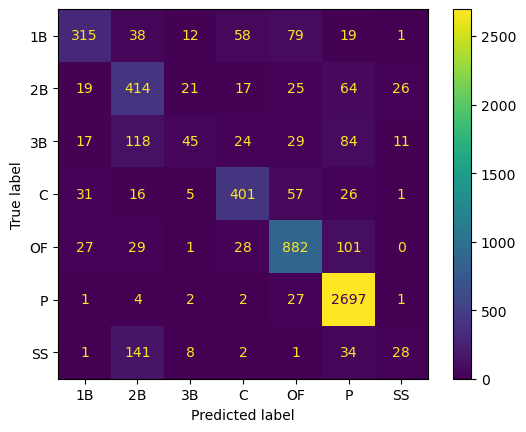

In [20]:
rf = RandomForestClassifier(n_jobs = -1, random_state=4)
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)
print('Train:', rf.score(X_train, y_train).round(5), '\nTest:', rf.score(X_test, y_test).round(5))
cm = confusion_matrix(y_test,rf_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['1B','2B','3B','C','OF','P','SS'])
cm_display.plot()
plt.show()

In [21]:
param_grid = {'n_estimators':[int(x) for x in np.linspace(10,1000,10)],
             'min_samples_split':[2,5], 'min_samples_leaf':[.25,.5,.75,1],
             'max_features':['sqrt','log2',None],
             'bootstrap':[True,False]}
rf_random = RandomizedSearchCV(estimator = rf, param_distributions=param_grid,n_iter=10, cv=4, verbose=2, n_jobs=-1)
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)
print(rf_random.best_estimator_)
rf_best=rf_random.best_estimator_

Fitting 4 folds for each of 10 candidates, totalling 40 fits
{'n_estimators': 450, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}
RandomForestClassifier(max_features='log2', min_samples_split=5,
                       n_estimators=450, n_jobs=-1, random_state=4)


Train: 0.98626 
Test: 0.80284


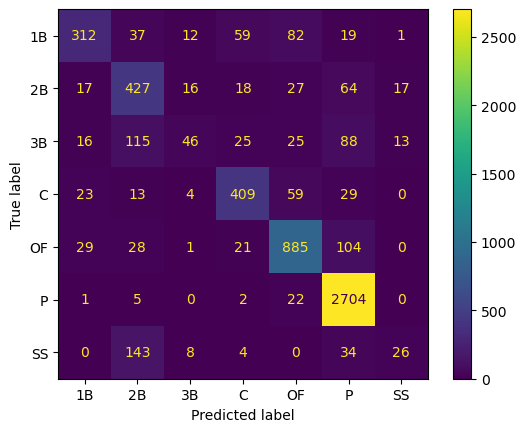

In [22]:
rf_random_pred = rf_random.predict(X_test)
print('Train:', rf_random.score(X_train, y_train).round(5), '\nTest:', rf_random.score(X_test, y_test).round(5))
cm_random = confusion_matrix(y_test,rf_random_pred)
cm_random_display = ConfusionMatrixDisplay(confusion_matrix = cm_random, display_labels = ['1B','2B','3B','C','OF','P','SS'])
cm_random_display.plot()
plt.show()

In [23]:
print(classification_report(y_test,rf_random_pred))

              precision    recall  f1-score   support

          1B       0.78      0.60      0.68       522
          2B       0.56      0.73      0.63       586
          3B       0.53      0.14      0.22       328
           C       0.76      0.76      0.76       537
          OF       0.80      0.83      0.82      1068
           P       0.89      0.99      0.94      2734
          SS       0.46      0.12      0.19       215

    accuracy                           0.80      5990
   macro avg       0.68      0.60      0.61      5990
weighted avg       0.79      0.80      0.78      5990



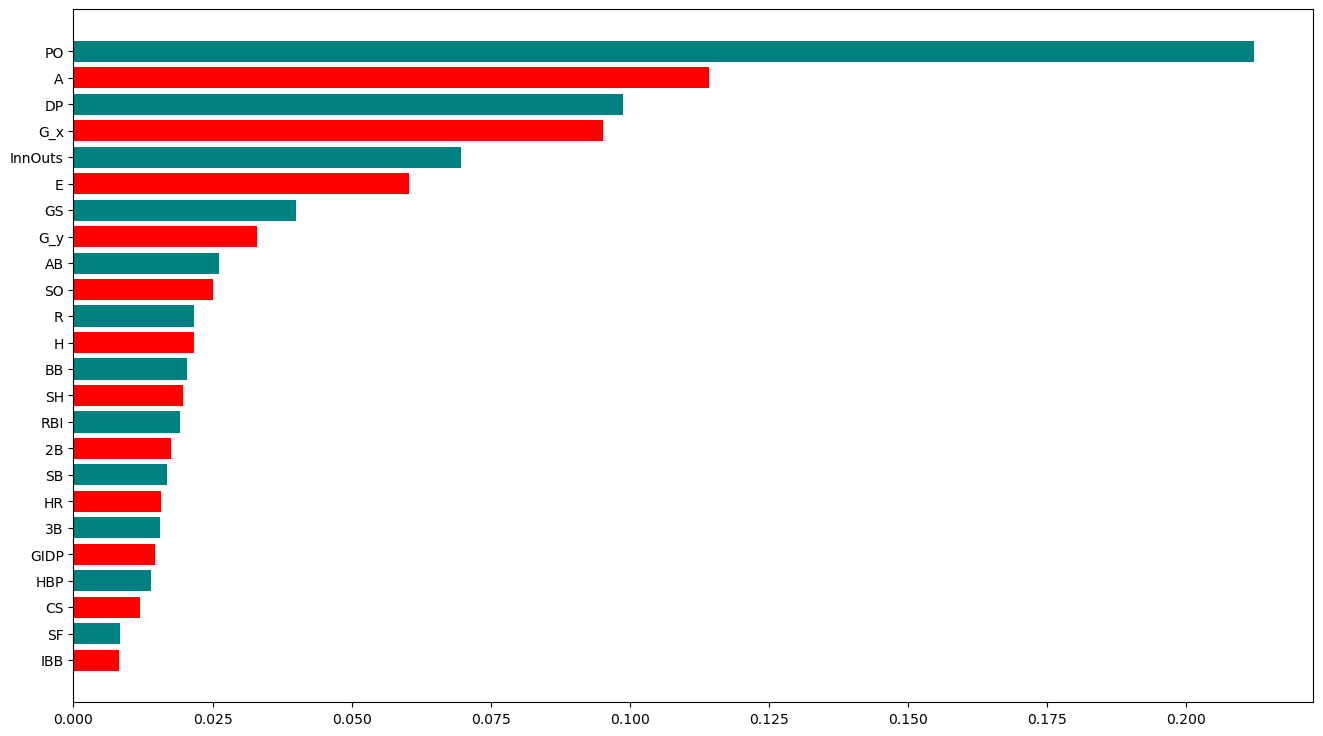

In [24]:
# get importance
importance = rf.feature_importances_
test = dict(zip(list(X),importance))
test = dict(sorted(test.items(), key=lambda item: item[1]))
fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(*zip(*test.items()),color=['red','teal'])
plt.show()

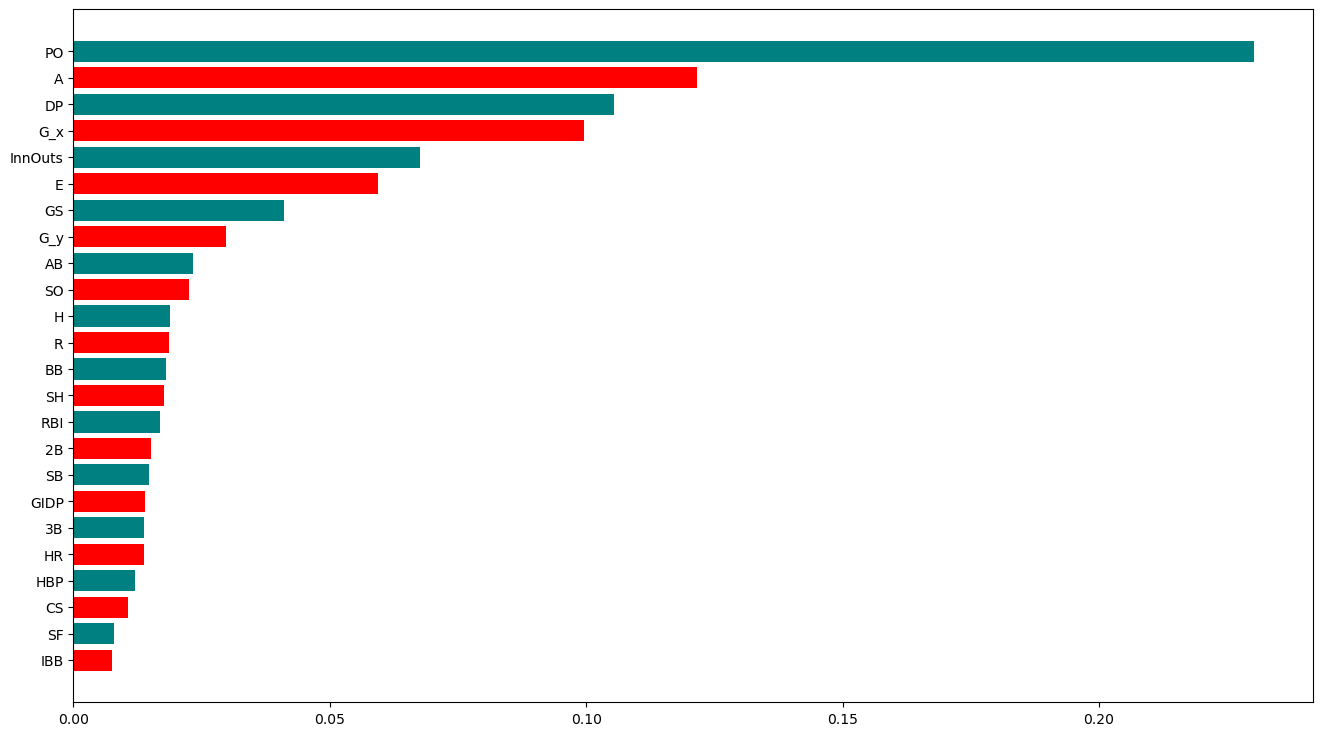

In [25]:
importance = rf_best.feature_importances_
test = dict(zip(list(X),importance))
test = dict(sorted(test.items(), key=lambda item: item[1]))
fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(*zip(*test.items()),color = ['red','teal'])
plt.show()

In [48]:
models = [
    GaussianNB(),
    SGDClassifier(shuffle = True),
    KNeighborsClassifier(n_neighbors=4),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    rf_best
]

table = PrettyTable()
table.field_names = ['Model', 'Data', 'Accuracy', 'Precision', 'Recall', 'F1', 'Train Acc']

In [49]:
def fit_model(model,X_train,X_test,y_train,y_test, df_name):
    model = model.fit(X_train, y_train)
    pred = model.predict(X_test)
    acc = round(accuracy_score(y_test, pred), 6)
    precision = round(precision_score(y_test, pred, average ='micro'), 3)
    recall = round(np.sqrt(recall_score(y_test, pred, average ='micro')), 3)
    f1 = round(f1_score(y_test, pred, average ='micro'), 3)
    train_acc = model.score(X_train, y_train).round(6)
    table.add_row([model, df_name, acc, precision, recall, f1, train_acc]) 
    return [model, df_name, acc, precision, recall, f1, train_acc] 
results = []
fitted_models = []
for model in models:
    model_result = fit_model(model,X_train,X_test,y_train,y_test, 'features_df')
    results.append(model_result)
    fitted_models.append(model_result[0])

table

Model,Data,Accuracy,Precision,Recall,F1,Train Acc
GaussianNB(),features_df,0.494825,0.495,0.703,0.495,0.493202
SGDClassifier(),features_df,0.610518,0.611,0.781,0.611,0.610634
KNeighborsClassifier(n_neighbors=4),features_df,0.662604,0.663,0.814,0.663,0.780163
DecisionTreeClassifier(),features_df,0.729048,0.729,0.854,0.729,0.999356
RandomForestClassifier(),features_df,0.796995,0.797,0.893,0.797,0.999356
"RandomForestClassifier(max_features='log2', min_samples_split=5, n_estimators=450, n_jobs=-1, random_state=4)",features_df,0.802838,0.803,0.896,0.803,0.98626


In [58]:
@interact
def generate_report(model=fitted_models):
    """Generates desired report for specified model."""
    plt.close()
    conf_mat = plt.show(ConfusionMatrixDisplay.from_estimator(model, X_test, y_test,cmap = 'summer' ))
    clf_rep =  print(classification_report(model.predict(X_test), y_test))

    return clf_rep 

interactive(children=(Dropdown(description='model', options=(GaussianNB(), SGDClassifier(), KNeighborsClassifi…

In [29]:
scaled_X = StandardScaler().fit_transform(X.values)

In [30]:
pca = PCA(n_components=4)
reduced_features = pca.fit_transform(scaled_X)

reduced_df = pd.DataFrame(reduced_features, columns=['PCA1','PCA2','PCA3','PCA4']).merge(y, on=y.index)

In [31]:
reduced_df.head()

,key_0,PCA1,PCA2,PCA3,PCA4,POS
0,aardsda01,-2.456921,0.302937,0.070861,-0.004175,P
1,aaronha01,23.213433,3.489480,-5.499756,-7.115538,OF
2,aaronto01,6.935828,-2.235096,-1.920178,-0.141472,1B
3,aasedo01,3.083855,-1.508986,-0.720184,-0.248723,P
4,abadan01,-2.619235,0.001413,0.046080,0.093744,1B


In [32]:
pca_y = reduced_df['POS']
pca_x = reduced_df.drop(['POS','key_0'], axis = 1)
pca_x_train, pca_x_test, pca_y_train, pca_y_test = train_test_split(pca_x,pca_y,test_size=0.3)

In [33]:
for model in models:
    model_result = fit_model(model,pca_x_train, pca_x_test, pca_y_train, pca_y_test, 'PCA_df')
    results.append(model_result)
    fitted_models.append(model_result[0])
table

Model,Data,Accuracy,Precision,Recall,F1,Train Acc
GaussianNB(),features_df,0.495,0.495,0.703,0.495,0.493
SGDClassifier(),features_df,0.589,0.589,0.768,0.589,0.587
KNeighborsClassifier(n_neighbors=4),features_df,0.663,0.663,0.814,0.663,0.78
DecisionTreeClassifier(),features_df,0.727,0.727,0.853,0.727,0.999
RandomForestClassifier(),features_df,0.795,0.795,0.892,0.795,0.999
"RandomForestClassifier(max_features='log2', min_samples_split=5, n_estimators=450, n_jobs=-1, random_state=4)",features_df,0.803,0.803,0.896,0.803,0.986
GaussianNB(),PCA_df,0.488,0.488,0.699,0.488,0.496
SGDClassifier(),PCA_df,0.511,0.511,0.715,0.511,0.513
KNeighborsClassifier(n_neighbors=4),PCA_df,0.52,0.52,0.721,0.52,0.677
DecisionTreeClassifier(),PCA_df,0.458,0.458,0.677,0.458,0.999


In [34]:
data = pd.DataFrame.from_records(results,columns=['Model', 'Data', 'Accuracy', 'Precision', 'Recall', 'F1', 'Train Acc'])

In [35]:
data

,Model,Data,Accuracy,Precision,Recall,F1,Train Acc
0,GaussianNB(),features_df,0.495,0.495,0.703,0.495,0.493
1,SGDClassifier(),features_df,0.589,0.589,0.768,0.589,0.587
2,KNeighborsClassifier(n_neighbors=4),features_df,0.663,0.663,0.814,0.663,0.780
3,DecisionTreeClassifier(),features_df,0.727,0.727,0.853,0.727,0.999
4,"(DecisionTreeClassifier(max_features='auto', r...",features_df,0.795,0.795,0.892,0.795,0.999
5,"(DecisionTreeClassifier(max_features='log2', m...",features_df,0.803,0.803,0.896,0.803,0.986
6,GaussianNB(),PCA_df,0.488,0.488,0.699,0.488,0.496
7,SGDClassifier(),PCA_df,0.511,0.511,0.715,0.511,0.513
8,KNeighborsClassifier(n_neighbors=4),PCA_df,0.520,0.520,0.721,0.520,0.677
9,DecisionTreeClassifier(),PCA_df,0.458,0.458,0.677,0.458,0.999


<AxesSubplot:xlabel='Data', ylabel='Train Acc'>

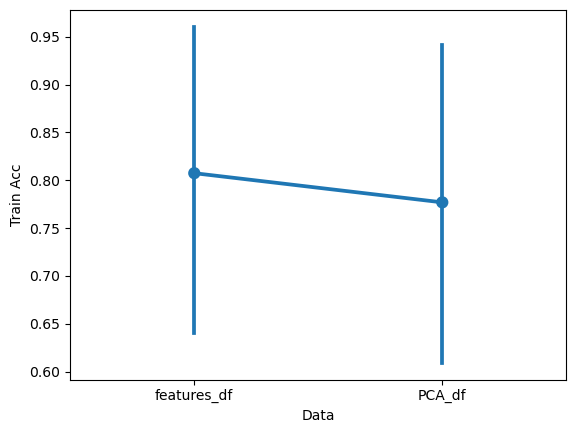

In [36]:
sns.pointplot(data=data, x ='Data',y='Train Acc')

<AxesSubplot:xlabel='Accuracy', ylabel='Train Acc'>

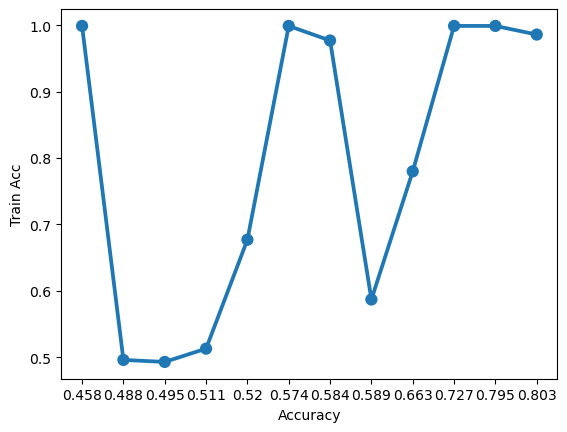

In [37]:
sns.pointplot(data=data, x='Accuracy', y='Train Acc')